# Airbnb Listing Prices in Hawaii
### Zhentao Hou and Min Che
<br></br>

In [1]:
# load rpy2 and libraries
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
# general imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from wordcloud import WordCloud, STOPWORDS

pd.options.mode.chained_assignment = None

## Listing Price Overview
Heatmap showing the distribution of Airbnb listing prices by location

In [3]:
# load listings dataset
df = pd.read_csv("data/listings.csv")

In [4]:
# clean data
sp = df.loc[df.host_is_superhost == 't']
ns = df.loc[df.host_is_superhost == 'f']

lat = df['latitude'].dropna()
lon = df['longitude'].dropna()
price = df['price'].dropna()
price = price.str.replace(r'$', '')
price = price.str.replace(r'\,', '')
price = pd.to_numeric(price)
max_price = float(price.max())

In [5]:
# plot heatmap
hmap = folium.Map(location=[20.859778, -156.490857], zoom_start=10)
hm_wide = HeatMap(list(zip(lat, lon, price)),
                  min_opacity=0.2,
                  max_val=max_price,
                  radius=17, blur=15,
                  max_zoom=13,
                 )
hmap.add_child(hm_wide)
# hmap.save('heatmap.html')

## Price vs Island and Room Type
Horizontal bar plot showing the Airbnb listing prices by location and room type

In [6]:
# load listings_summary dataset
hawaii = pd.read_csv("data/listings_summary.csv")

In [7]:
hawaii.head()

id                                               name  host_id  \
0  3002  OCEAN VIEW 1BLK2BEACH,LANAI A/C,FULL KITCH,CEN...     3364   
1  5065                                           MAUKA BB     7257   
2  5269                                       'Auwai Suite     7620   
3  5387                Hale Koa Studio & 1 Bedroom Units!!     7878   
4  5389                                      Keauhou Villa     7878   

   host_name neighbourhood_group         neighbourhood  latitude  longitude  \
0      Lynne            Honolulu  Primary Urban Center  21.27603 -157.82210   
1      Wayne              Hawaii               Hamakua  20.04095 -155.43251   
2  Lea & Pat              Hawaii          South Kohala  20.02621 -155.70145   
3     Edward              Hawaii            South Kona  19.43119 -155.88079   
4     Edward              Hawaii            North Kona  19.56413 -155.96347   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room     69               1                232  2019-07-13   
1  Entire home/apt     85               2                 36  2019-05-16   
2  Entire home/apt    130               3                  4  2019-07-23   
3  Entire home/apt     92               5                159  2019-07-15   
4  Entire home/apt    299               6                 13  2019-02-10   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               2.10                               1                32  
1               0.46                               2               358  
2               0.04                               7               336  
3               1.38                               3               329  
4               0.19                               3               276

In [8]:
# calculate mean price per neighborhood group per room type
price = hawaii.groupby(["neighbourhood_group", "room_type"]).price.mean().reset_index()
price["neighbourhood_group"] = (price["neighbourhood_group"].str.replace("Hawaii", "Big Island")
                                .str.replace("Honolulu", "Oahu"))

# change neighbourhood_group and room_type column to categorical
hood = price.loc[price.room_type == "Entire home/apt"].sort_values("price")["neighbourhood_group"]
room = ["Shared room", "Private room", "Entire home/apt"]
price["neighbourhood_group"] = pd.Categorical(price["neighbourhood_group"], categories=hood, ordered=True)
price["room_type"] = pd.Categorical(price["room_type"], categories=room, ordered=True)

In [9]:
price

neighbourhood_group        room_type       price
0           Big Island  Entire home/apt  359.977442
1           Big Island     Private room  115.572536
2           Big Island      Shared room   54.242424
3                 Oahu  Entire home/apt  290.034789
4                 Oahu     Private room  156.522212
5                 Oahu      Shared room   49.901235
6                Kauai  Entire home/apt  359.407194
7                Kauai     Private room  278.737705
8                Kauai      Shared room  125.000000
9                 Maui  Entire home/apt  385.081073
10                Maui     Private room  326.212054
11                Maui      Shared room   37.608696

In [10]:
%R -i price

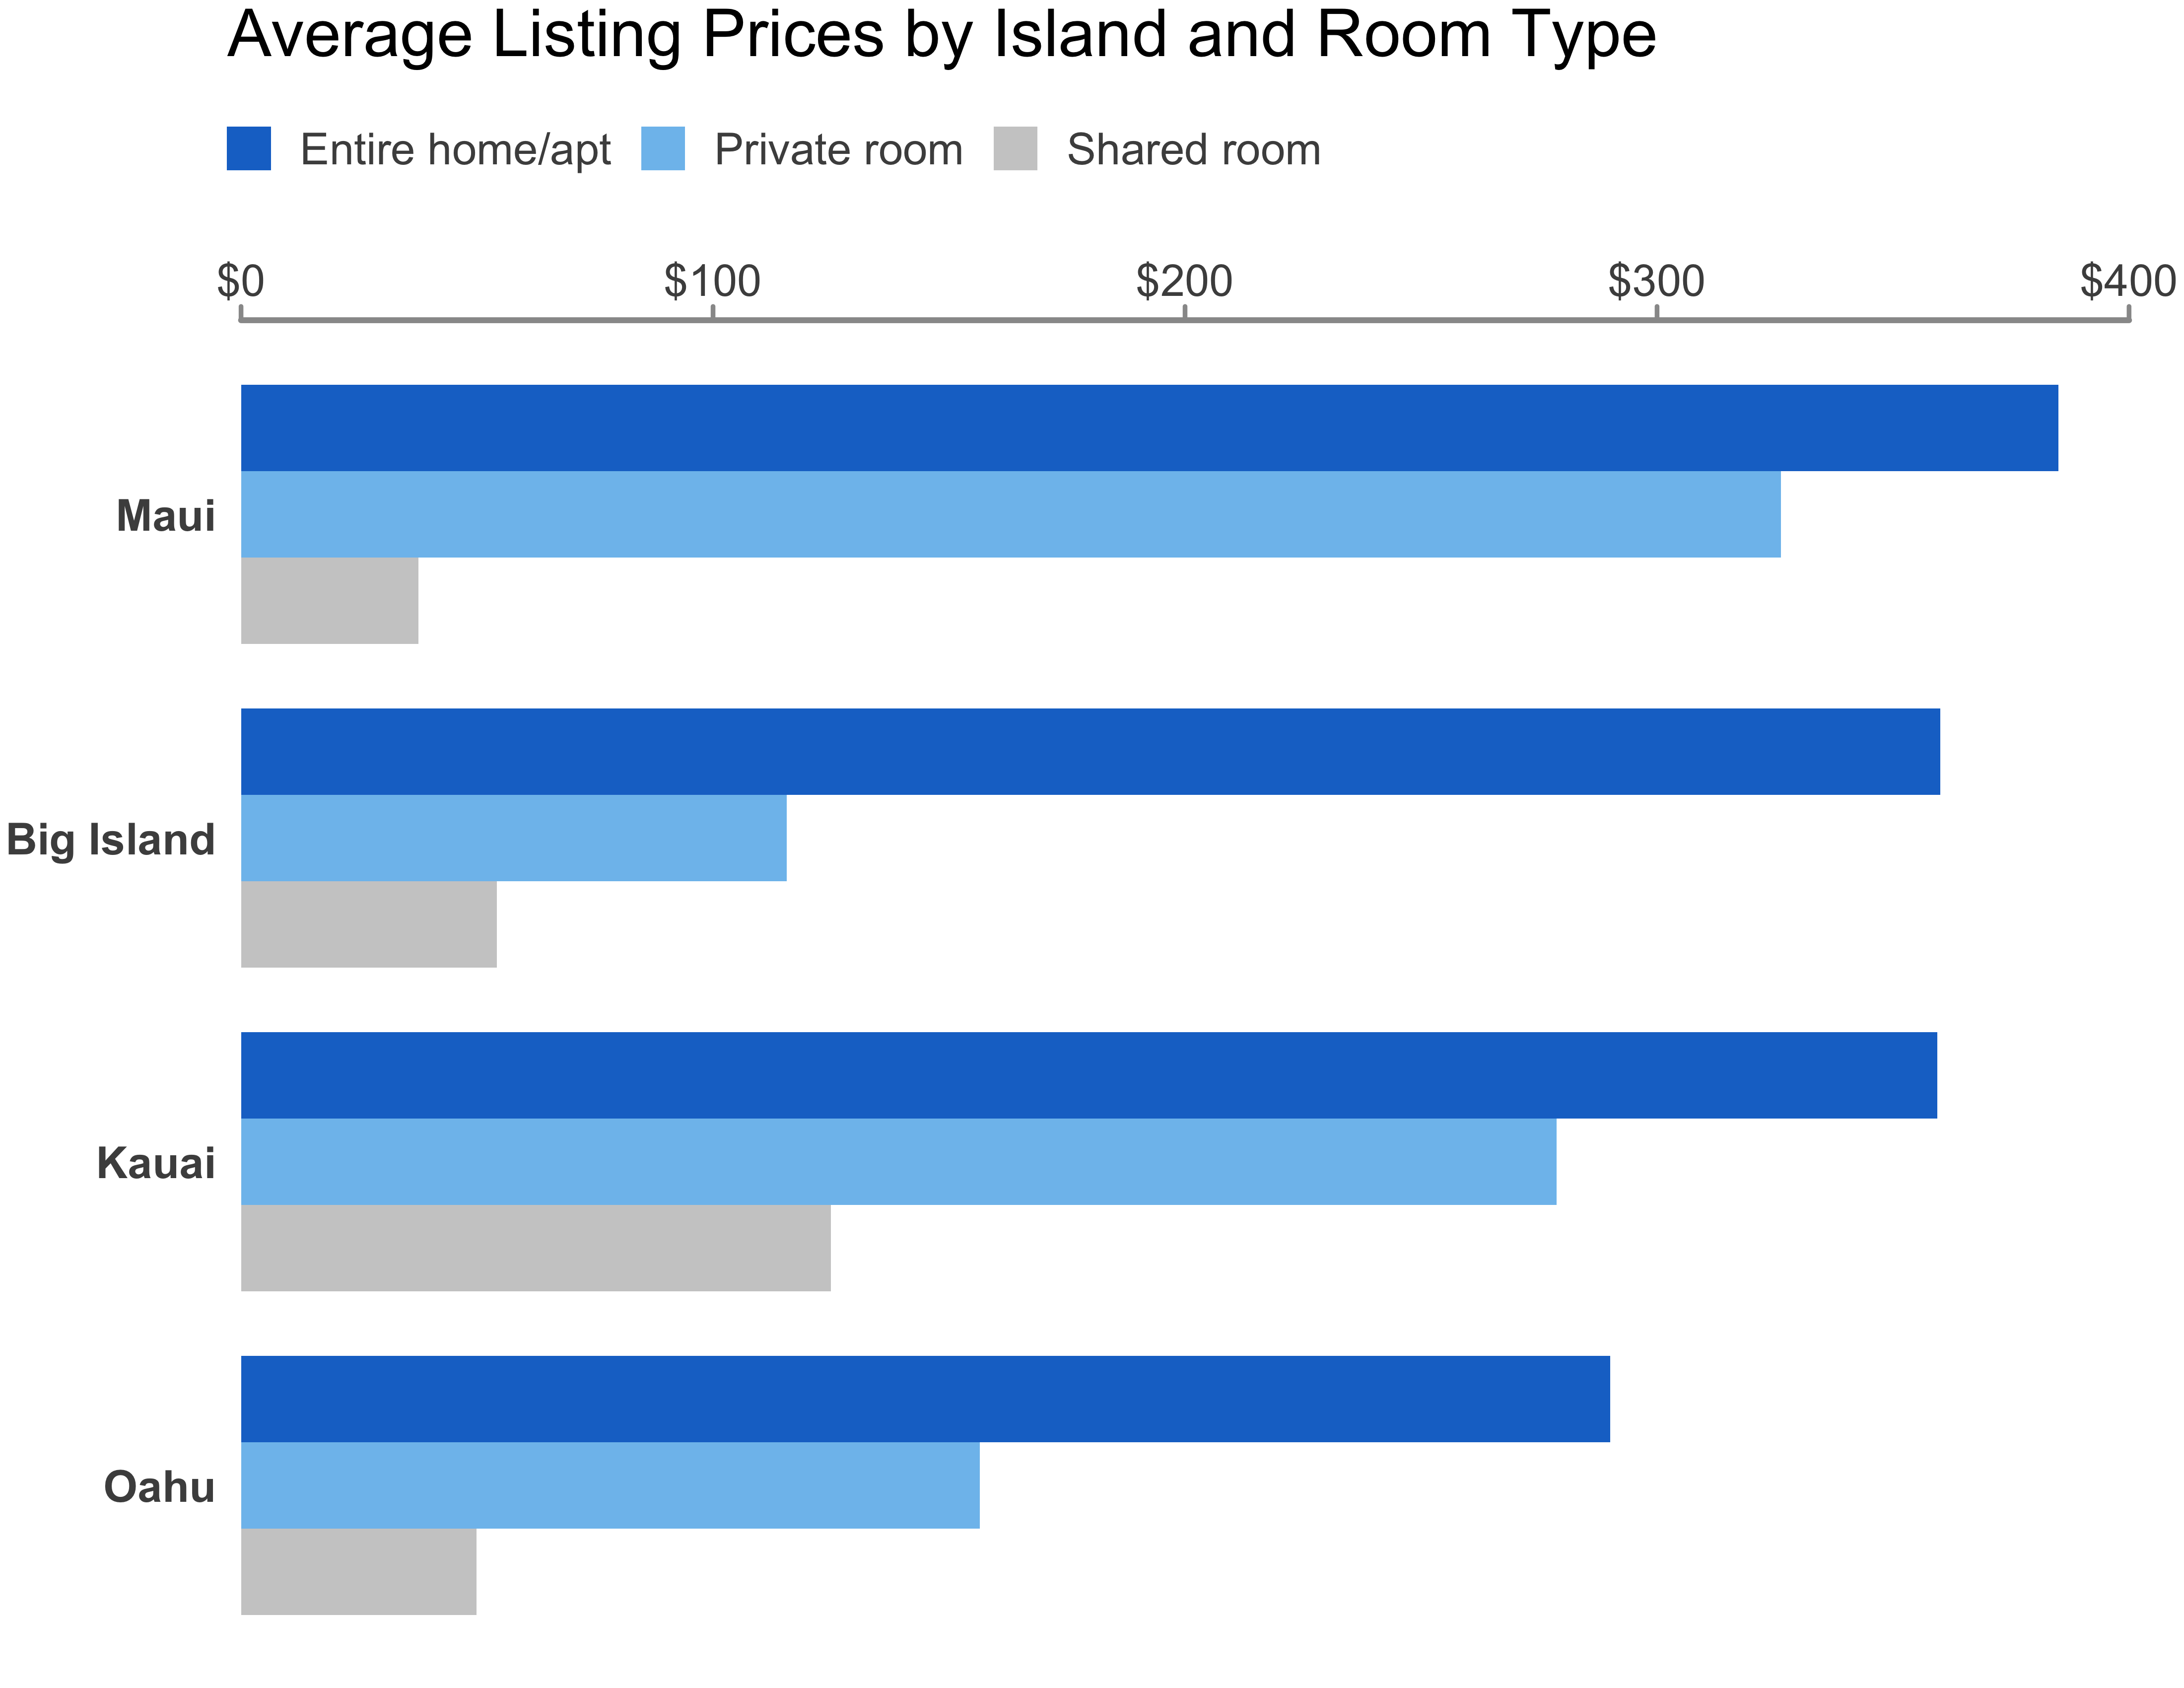

In [11]:
%%R -w 11 -h 8.5 --units in -r 400
(ggplot()
 + geom_bar(aes(x=neighbourhood_group, y=price, fill=as.factor(room_type)), data=price,
            position="dodge", stat="identity", width=0.8)
 + scale_fill_manual(values=c("gray80", "skyblue2", "dodger blue3"))
 + scale_y_continuous(label=dollar, limits=c(0, 400), breaks=seq(0, 400, by=100), expand=c(0, 0), position="right")
 + ggtitle("Average Listing Prices by Island and Room Type")
 + theme_minimal(base_size=20)
 + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), legend.title=element_blank(),
         legend.text=element_text(color="gray30"), legend.position="top", legend.justification=c(-0.1, 0),
         axis.line.x=element_line(size=1, color="gray60"), axis.ticks.x=element_line(size=0.8, color="gray60"),
         axis.title.x=element_blank(), axis.title.y=element_blank(), axis.text.y=element_text(face="bold"),
         plot.margin=margin(3, 20, 3, 2), plot.title=element_text(hjust=-0.03))
 + guides(fill=guide_legend(reverse=TRUE))
 + coord_flip()
)
# ggsave("avg_price.pdf", width=11, height=8.5, units="in")

## Price over Time
Scatter plot showing the Airbnb listing price changes over time (month) for different room types

In [12]:
# load calendar dataset, price vs date
price_month = pd.read_csv("data/calendar.csv", parse_dates=["date"])

In [13]:
price_month.head()

listing_id       date available    price adjusted_price  minimum_nights  \
0        3002 2019-08-06         f   $67.00         $67.00               1   
1       14512 2019-08-06         t  $399.00        $399.00               3   
2       14512 2019-08-07         t  $399.00        $399.00               3   
3       14512 2019-08-08         t  $399.00        $399.00               3   
4       14512 2019-08-09         f  $399.00        $399.00               3   

   maximum_nights  
0               3  
1             365  
2             365  
3             365  
4             365

In [14]:
# select columns and clean data
price_month = price_month[["listing_id", "date", "price"]]
price_month["price"] = price_month.price.str.replace("$", "").str.replace(",", "").astype(float)

In [15]:
# select listing ids and room types from listing dataset
ids = hawaii[["id", "room_type"]]

# join ids and price_month datasets to calculate the mean price per room type per month
price_month_room = pd.merge(price_month, ids, left_on="listing_id", right_on="id", how="inner")

In [16]:
price_month_room.head()

listing_id       date  price    id     room_type
0        3002 2019-08-06   67.0  3002  Private room
1        3002 2019-08-07   65.0  3002  Private room
2        3002 2019-08-08   65.0  3002  Private room
3        3002 2019-08-09   65.0  3002  Private room
4        3002 2019-08-10   65.0  3002  Private room

In [17]:
# groupby month and room type
price_month_room["month_num"] = price_month_room.date.dt.month
price_month_room["month"] = price_month_room.date.dt.strftime("%b")
avgprice_month_room = price_month_room.groupby(["room_type", "month_num", "month"]).price.mean().reset_index()

# change month to categorical data
avgprice_month_room["month"] = pd.Categorical(avgprice_month_room["month"],
                                              categories=avgprice_month_room["month"].unique(), ordered=True)

In [18]:
avgprice_month_room.head()

room_type  month_num month       price
0  Entire home/apt          1   Jan  365.817630
1  Entire home/apt          2   Feb  356.749028
2  Entire home/apt          3   Mar  348.877227
3  Entire home/apt          4   Apr  328.377425
4  Entire home/apt          5   May  314.992207

In [19]:
# calculate average listing price per room_type
avgprice_room = avgprice_month_room.groupby("room_type").price.mean().reset_index()

In [20]:
avgprice_room

room_type       price
0  Entire home/apt  330.311202
1     Private room  162.014367
2      Shared room   48.177692

In [21]:
# select the lowest and highest prices
avgprice_entire = avgprice_month_room.loc[avgprice_month_room.room_type == "Entire home/apt"]
lowest = avgprice_entire.loc[avgprice_entire.price == avgprice_entire.price.min()]
highest = avgprice_entire.loc[avgprice_entire.price == avgprice_entire.price.max()]
avgprice_select = pd.concat([lowest, highest], axis=0)

In [22]:
avgprice_select

room_type  month_num month       price
8   Entire home/apt          9   Sep  295.841234
11  Entire home/apt         12   Dec  370.436797

In [23]:
%R -i avgprice_month_room
%R -i avgprice_room
%R -i avgprice_select

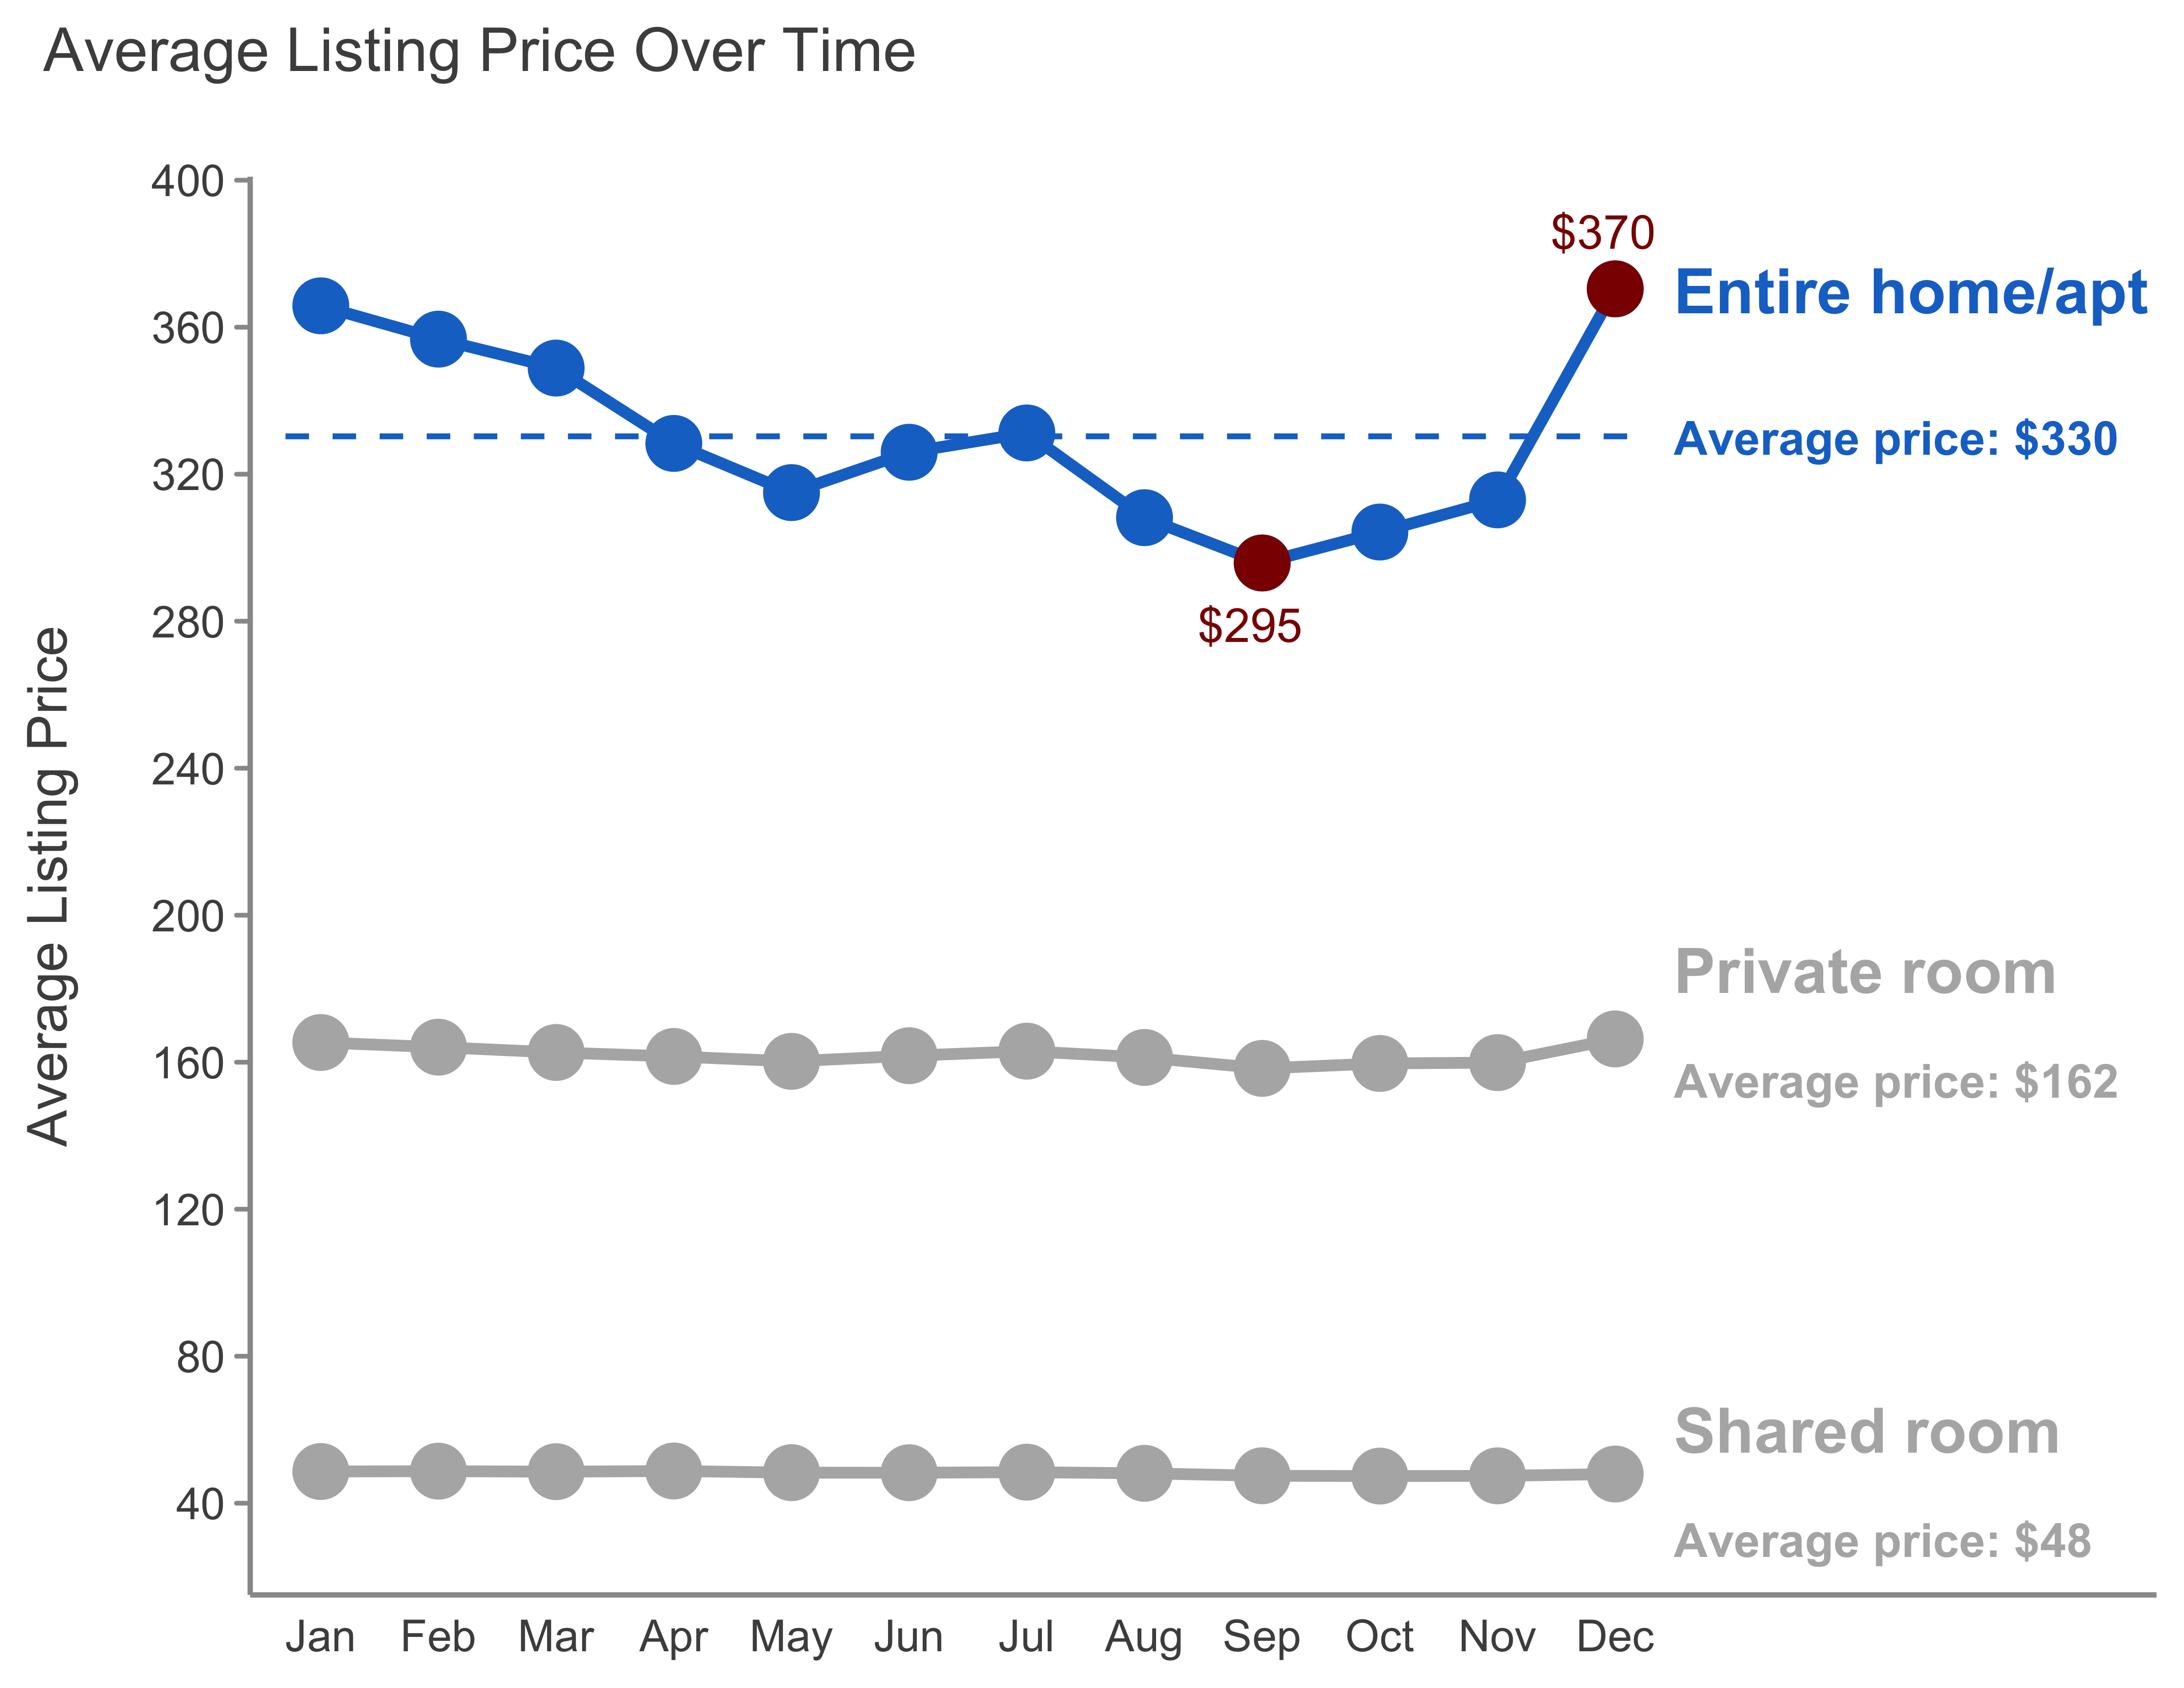

In [24]:
%%R -w 11 -h 8.5 --units in -r 400
(ggplot()
 + geom_line(aes(x=month, y=price, group=as.factor(room_type), color=as.factor(room_type)), data=avgprice_month_room,
             size=2)
 + geom_segment(aes(x=0.7, xend=12.3, y=330.3, yend=330.3), linetype="dashed", size=1, color="dodger blue3")
 + geom_point(aes(x=month, y=price, color=as.factor(room_type)), data=avgprice_month_room, size=9)
 + geom_point(aes(x=month, y=price), data=avgprice_select, size=9, color="red4")
 + annotate("text", x=12.5, y=370, label="Entire home/apt", size=8, color="dodger blue3", fontface="bold", hjust=0)
 + annotate("text", x=12.5, y=330, label="Average price: $330", size=6, color="dodger blue3", fontface="bold", hjust=0)
 + annotate("text", x=11.9, y=386, label="$370", size=6, color="red4")
 + annotate("text", x=8.9, y=279, label="$295", size=6, color="red4")
 + annotate("text", x=12.5, y=185, label="Private room", size=8, color="gray70", fontface="bold", hjust=0)
 + annotate("text", x=12.5, y=155, label="Average price: $162", size=6, color="gray70", fontface="bold", hjust=0)
 + annotate("text", x=12.5, y=60, label="Shared room", size=8, color="gray70", fontface="bold", hjust=0)
 + annotate("text", x=12.5, y=30, label="Average price: $48", size=6, color="gray70", fontface="bold", hjust=0)
 + scale_color_manual(values=c("dodger blue3", "gray70", "gray70"))
 + scale_x_discrete(limits=c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
                             "", "", "", ""))
 + scale_y_continuous(breaks=seq(40, 400, by=40), expand=c(0.042, 0))
 + ggtitle("Average Listing Price Over Time\n")
 + ylab("Average Listing Price\n")
 + theme_minimal(base_size=20)
 + theme(panel.background=element_blank(), panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
         plot.title=element_text(color="gray30", size=22, hjust=-0.2), axis.line=element_line(color="gray60"),
         axis.title=element_text(color="gray30"), axis.title.x=element_blank(), axis.ticks.x=element_blank(),
         axis.ticks.y=element_line(size=0.8, color="gray60"), legend.position="none")
)
# ggsave("seasonal_trend.pdf", width=11, height=8.5, units="in")

## Superhost vs Non-superhost
Line plot showing the differences of review scores and listing prices between superhosts and non-superhosts

In [28]:
# calculate the mean price for all superhosts
sp['price'] = sp['price'].str.replace(r'$','')
sp['price'] = sp['price'].str.replace(r'\,','')
sp['price'] = pd.to_numeric(sp['price'])
sp['price'].mean()

308.0174463685707

In [29]:
# calculate the mean price for all non-superhosts
ns['price'] = ns.price.dropna()
ns['price'] = ns['price'].str.replace(r'$','')
ns['price'] = ns['price'].str.replace(r'\,','')
ns['price'] = pd.to_numeric(ns['price'])
ns['price'].mean()

338.55764863059454

In [30]:
# create the mean price dataframe
mean_price = [sp['price'].mean(), ns['price'].mean()]
mean_price = pd.DataFrame(mean_price)
mean_price.columns = ['price']
mean_price['host_type'] = ['Superhost', 'Non-superhost']
mean_price['price'] = round(mean_price['price'], 0)
mean_price

price      host_type
0  308.0      Superhost
1  339.0  Non-superhost

In [31]:
# calculate review scores for all superhosts
sp_mean = sp[['review_scores_rating',
              'review_scores_communication',
              'review_scores_location',
              'review_scores_value']].mean()

In [32]:
# calculate review scores for all non-superhosts
ns_mean = ns[['review_scores_rating',
              'review_scores_communication',
              'review_scores_location',
              'review_scores_value']].mean()

In [33]:
# make the scale the same for all review scores
sp_mean['review_scores_rating'] = sp_mean.review_scores_rating/10
ns_mean['review_scores_rating'] = ns_mean.review_scores_rating/10

In [34]:
# create two dataframes for the review scores of superhosts and non-superhosts
sp_mean = sp_mean.to_frame().reset_index()
ns_mean = ns_mean.to_frame().reset_index()
sp_mean['host_type'] = 'Superhost'
ns_mean['host_type'] = 'Non-superhost'
sp_mean.rename(columns={'index': 'type', 0: 'score'}, inplace=True)
ns_mean.rename(columns={'index': 'type', 0: 'score'}, inplace=True)

In [35]:
sp_mean

type     score  host_type
0         review_scores_rating  9.724003  Superhost
1  review_scores_communication  9.933419  Superhost
2       review_scores_location  9.877296  Superhost
3          review_scores_value  9.701493  Superhost

In [36]:
ns_mean

type     score      host_type
0         review_scores_rating  9.305238  Non-superhost
1  review_scores_communication  9.618438  Non-superhost
2       review_scores_location  9.733419  Non-superhost
3          review_scores_value  9.263006  Non-superhost

In [37]:
# merge two dataframes
reviews = pd.concat([sp_mean, ns_mean])
reviews.reset_index()
reviews['score'] = round(reviews['score'], 2)

In [38]:
# clean data
reviews1 = reviews.loc[reviews.type == 'review_scores_communication']
reviews1['type'] = 'communication'

reviews2 = reviews.loc[reviews.type == 'review_scores_rating']
reviews2['type'] = 'overall'

reviews3 = reviews.loc[reviews.type == 'review_scores_location']
reviews3['type'] = 'location'

reviews4 = reviews.loc[reviews.type == 'review_scores_value']
reviews4['type'] = 'value'

In [39]:
# create the final review dataframe
reviews = pd.concat([reviews1, reviews2, reviews3, reviews4])
reviews

type  score      host_type
1  communication   9.93      Superhost
1  communication   9.62  Non-superhost
0        overall   9.72      Superhost
0        overall   9.31  Non-superhost
2       location   9.88      Superhost
2       location   9.73  Non-superhost
3          value   9.70      Superhost
3          value   9.26  Non-superhost

In [40]:
# create a dataframe without overall scores
overall = reviews.loc[reviews.type == "overall"]
others = reviews.loc[reviews.type != "overall"]
others

type  score      host_type
1  communication   9.93      Superhost
1  communication   9.62  Non-superhost
2       location   9.88      Superhost
2       location   9.73  Non-superhost
3          value   9.70      Superhost
3          value   9.26  Non-superhost

In [41]:
%R -i reviews
%R -i mean_price
%R -i overall
%R -i others

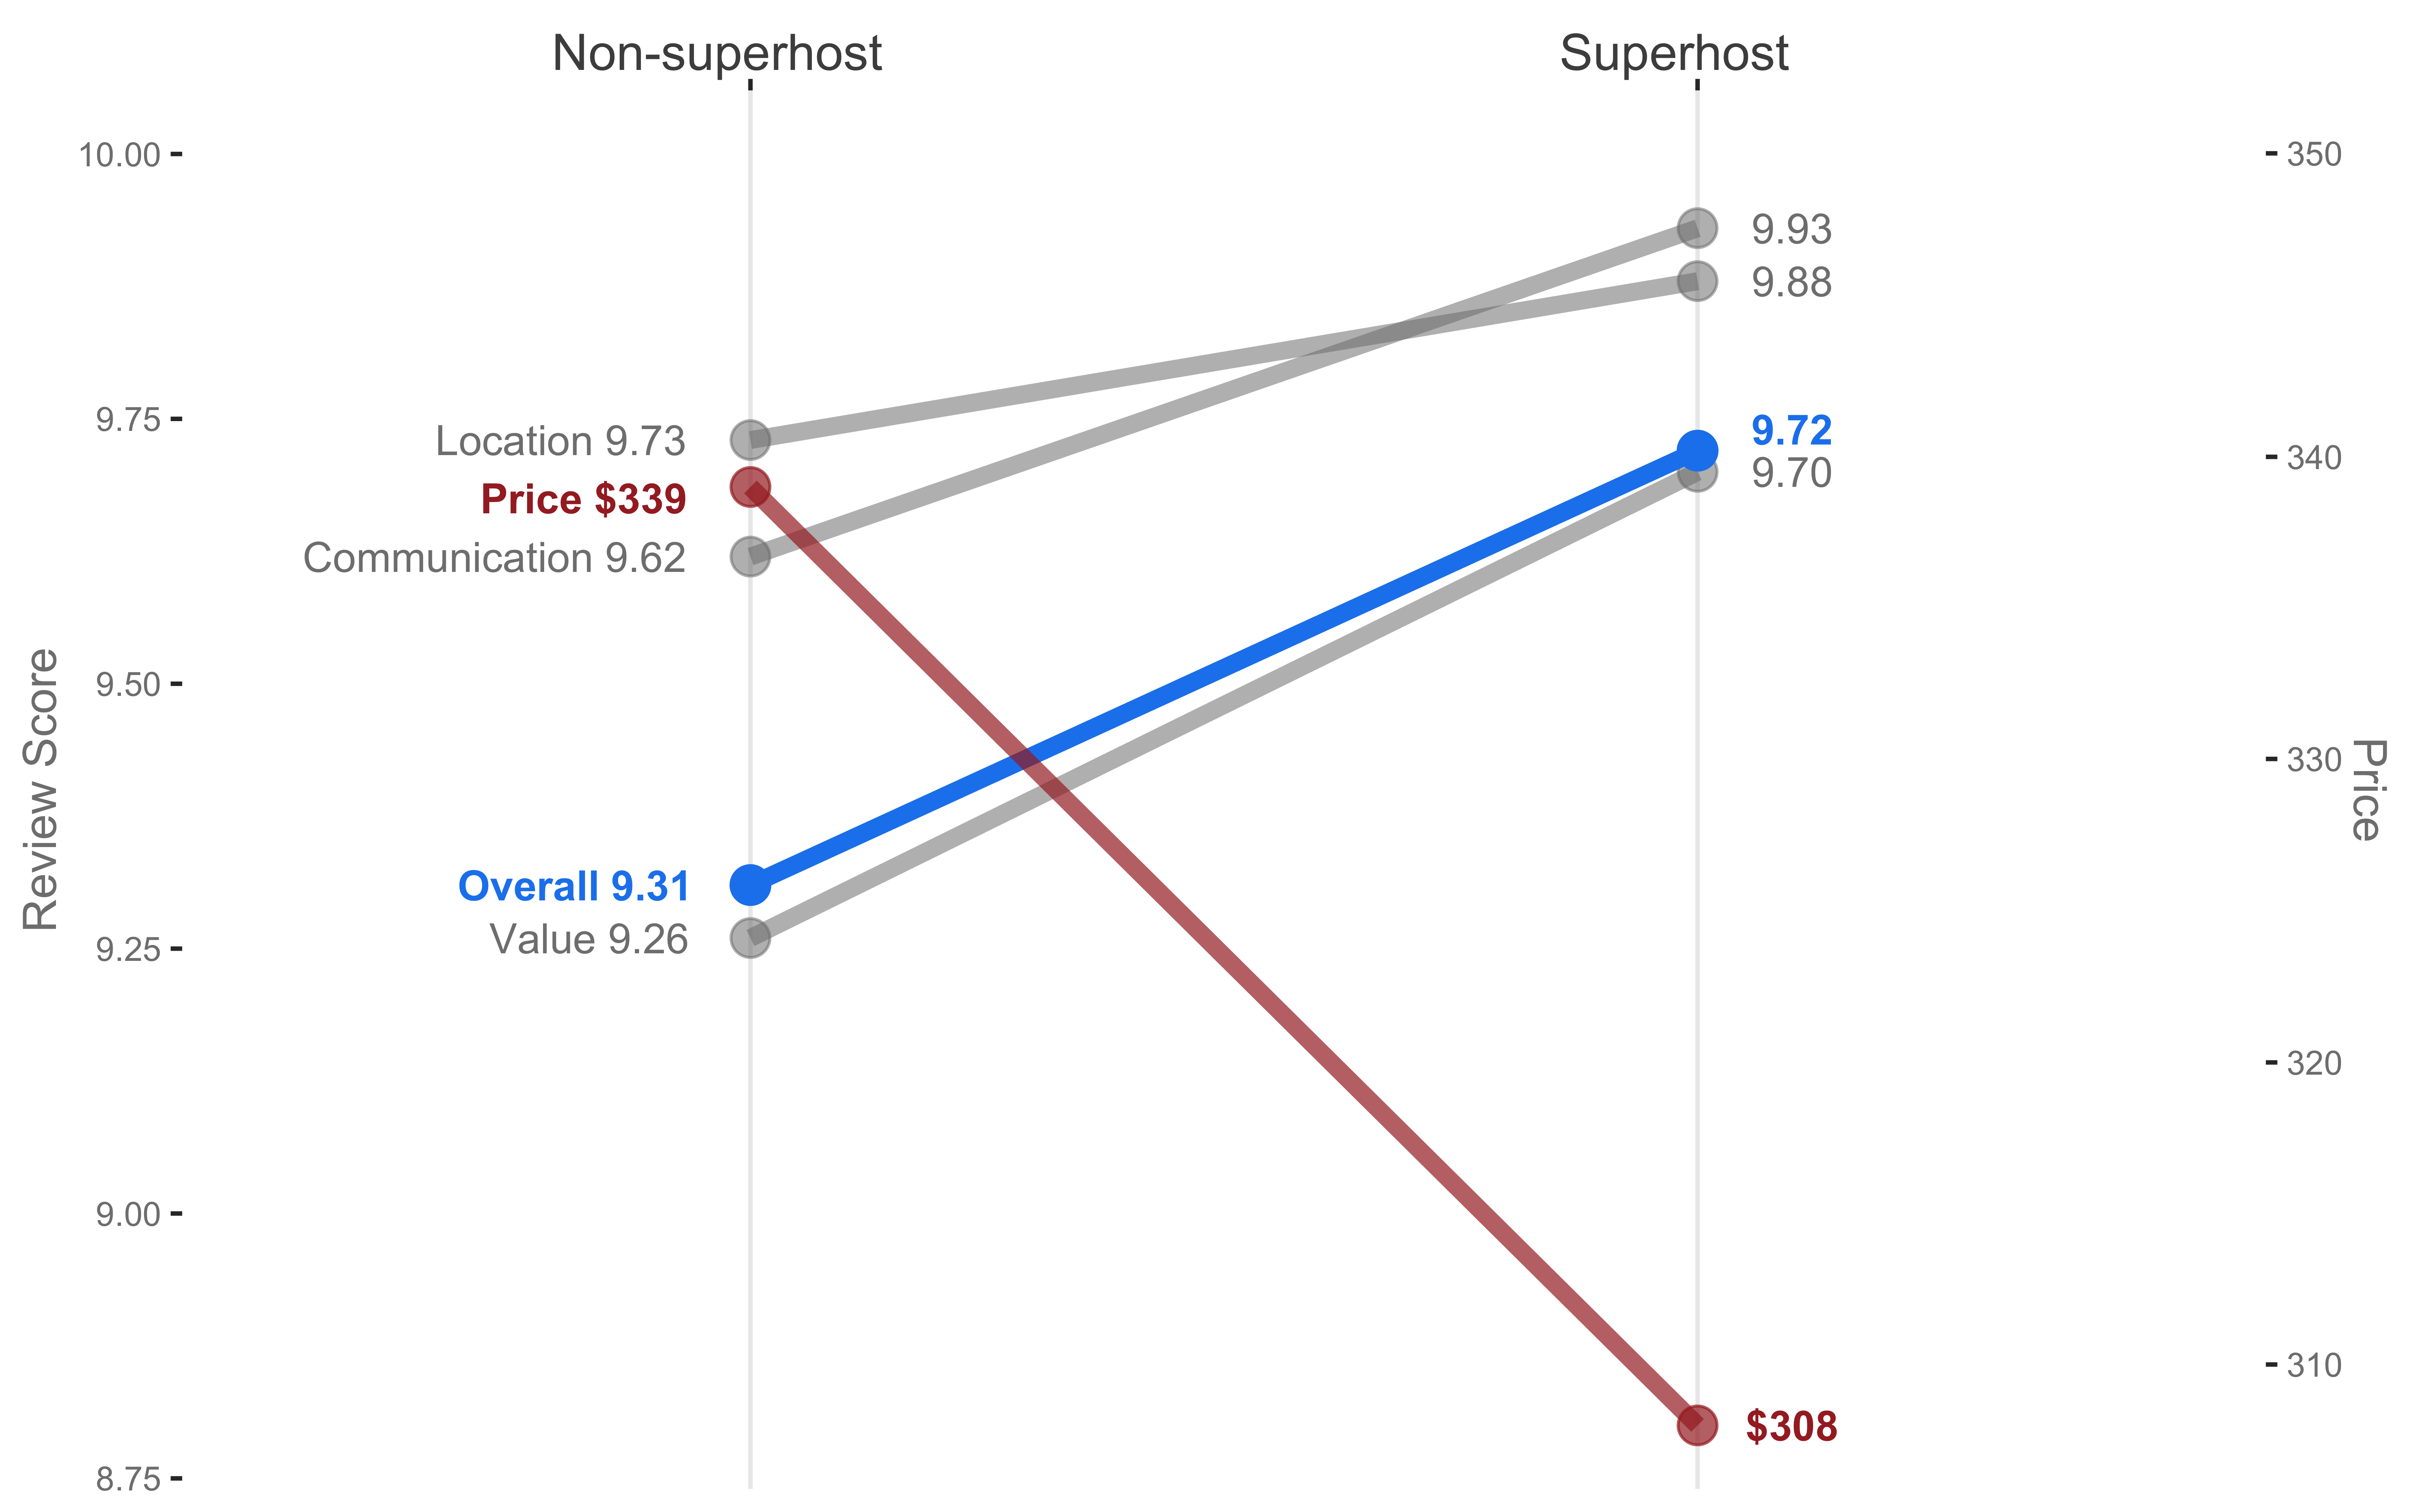

In [42]:
%%R -w 8 -h 5 --units in -r 800
(ggplot()
 + geom_line(aes(x=host_type, y=score, alpha=1, group=type), others, size=2, color='#808080')
 + geom_point(aes(x=host_type, y=score, alpha=1, group=type), others, size=4, color='#808080')
 + geom_line(aes(x=host_type, y=score, group=type), overall, size=2, color='dodgerblue2')
 + geom_point(aes(x=host_type, y=score, group=type), overall, size=4, color='dodgerblue2')
 + annotate("text", x=0.8, y=9.73, label="Location 9.73", size=3.5, color="#808080")
 + annotate("text", x=0.73, y=9.62, label="Communication 9.62", size=3.5, color="#808080")
 + annotate("text", x=0.83, y=9.26, label="Value 9.26", size=3.5, color="#808080")
 + annotate("text", x=0.824, y=9.675, label="Price $339", size=3.5, color="brown", fontface="bold")
 + annotate("text", x=0.815, y=9.31, label="Overall 9.31", size=3.5, color="dodgerblue2", fontface="bold")
 + annotate("text", x=2.1, y=9.93, label="9.93", size=3.5, color="#808080")
 + annotate("text", x=2.1, y=9.88, label="9.88", size=3.5, color="#808080")
 + annotate("text", x=2.1, y=9.7, label="9.70", size=3.5, color="#808080")
 + annotate("text", x=2.1, y=8.8, label="$308", size=3.5, color="brown", fontface="bold")
 + annotate("text", x=2.1, y=9.74, label="9.72", size=3.5, color="dodgerblue2", fontface="bold")
 + scale_x_discrete(position="top")
 + theme_bw()
 + theme(legend.position="none", panel.border=element_blank(), panel.grid.major.y=element_blank(),
         panel.grid.minor.y=element_blank(), axis.title.x=element_blank(),
         axis.title.y.right=element_text(color = "#808080"), axis.title.y.left=element_text(color = "#808080"),
         axis.text.x.top=element_text(size=12, hjust = 0.6), axis.text.y=element_text(size=8, color="#808080"),
         plot.title=element_text(size=14, face = "bold", hjust = 0.5), plot.subtitle=element_text(hjust = 0.5))
 + scale_y_continuous("Review Score", sec.axis=sec_axis(~ . * 350 / 10 , name="Price"), limits=c(8.8, 10))
 + geom_point(aes(x=host_type, y=price * 10 / 350), data=mean_price, color='brown', size=4, alpha=0.7)
 + geom_line(aes(x=host_type, y=price * 10 / 350), group=1, data=mean_price, color='brown', size=2, alpha=0.7))
# ggsave("superhost.html", width=11, height=8.5, unit="in")

## Listing Description
Word cloud showing the important listing aspects highlighted by superhosts and non-superhosts

In [43]:
# clean data
descriptions1 = " ".join(str(review) for review in sp.description)
descriptions2 = " ".join(str(review) for review in ns.description)

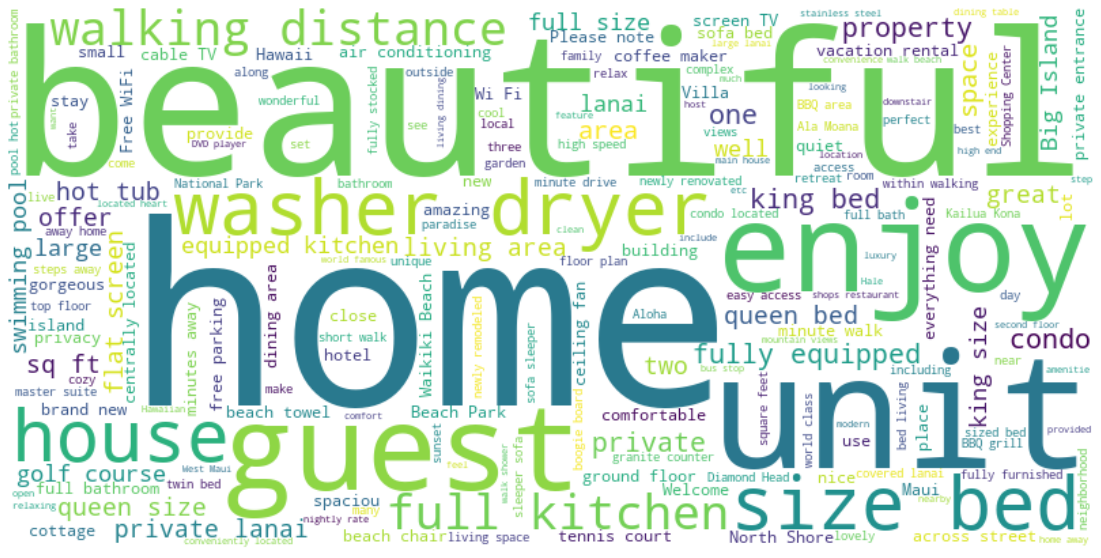

In [44]:
# wordcloud plot for superhosts
stopwords = set(STOPWORDS)
stopwords.update(["room", "bedroom", "apartment", "studio", "apt", "airbnb", "phone", "number", "ocean", "view"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(descriptions1)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

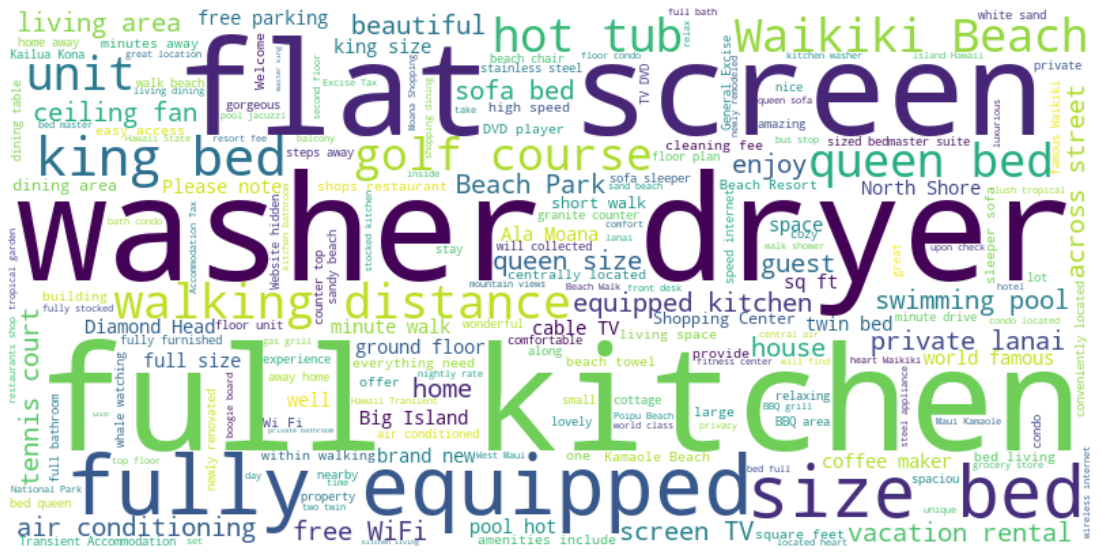

In [45]:
# wordcloud plot for non-superhosts
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(descriptions2)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()